# JSSP comparação entre euristicas Classicas: codigo fonte

## importação de libs

In [1]:
# %pip install mealpy
# %pip install numpy
%pip install -r ../requirements.txt



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import importlib.util
from classes.jssp import jssp
import numpy as np
from classes.jssp import jssp
from mealpy import SA
from mealpy.utils.space import FloatVar
import matplotlib.pyplot as plt
import time
import csv

## funções adicionais

In [3]:
def import_tests_cases(nome_dict : str) -> dict:

    caminho_absoluto = os.path.abspath("../tests/test1.py")

    spec = importlib.util.spec_from_file_location("modulo_temp", caminho_absoluto)
    
    if spec is None or spec.loader is None:
        raise ImportError(f"Não foi possível carregar o módulo do arquivo: {caminho_absoluto}")
    
    modulo = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(modulo)

    return getattr(modulo, nome_dict)

def decode_solution(solution_vec, operations):
    import numpy as np
    order = np.argsort(solution_vec)

    machine_available = {}
    job_operation_count = {}  # Conta quantas operações de cada job já foram executadas
    job_last_end_time = {}    # Último tempo de fim de operação para cada job

    print("Ordem com máquina usada:")

    for i, idx in enumerate(order):
        op = operations[idx]
        job = op["job"]
        
        # Inicializa contadores se necessário
        if job not in job_operation_count:
            job_operation_count[job] = 0
            job_last_end_time[job] = 0

        # Escolher a máquina que fica disponível primeiro
        machine = min(op["machines"], key=lambda m: machine_available.get(m, 0))

        # Considera tanto a disponibilidade da máquina quanto a precedência do job
        machine_ready_time = machine_available.get(machine, 0)
        job_ready_time = job_last_end_time[job]
        start_time = max(machine_ready_time, job_ready_time)
        end_time = start_time + op["duration"]

        # Atualiza os tempos
        machine_available[machine] = end_time
        job_last_end_time[job] = end_time
        job_operation_count[job] += 1

        print(f"{i+1}: {op['job']} Op{job_operation_count[job]}, Máquina {machine}, Duração {op['duration']}, Início {start_time}, Fim {end_time}, Equipamento {op.get('equipments', 'N/A')}")

def make_fitness_function(instance: jssp):
    """
    Função de fitness SEM penalidades massivas.
    Usa decodificação por PRIORIDADE que garante precedência automaticamente.
    Cada gene define a prioridade de uma operação específica.
    """
    operations = instance.get_flattened_operations()
    
    # Agrupa operações por job para validação
    jobs_operations = {}
    for op in operations:
        job = op["job"]
        if job not in jobs_operations:
            jobs_operations[job] = []
        jobs_operations[job].append(op)
    
    # Ordena operações de cada job por operation_id
    for job in jobs_operations:
        jobs_operations[job].sort(key=lambda op: op["operation_id"])

    def fitness(solution):
        """
        Decodifica solution como PRIORIDADES de operações.
        Ordena operações por prioridade, mas AJUSTA para respeitar precedência.
        """
        
        # Cria lista de (prioridade, índice_operação)
        priority_list = []
        for idx, priority_value in enumerate(solution):
            op = operations[idx]
            job = op["job"]
            operation_id = op.get("operation_id", 1)
            
            # AJUSTE CRÍTICO: adiciona offset baseado em operation_id
            # Isso garante que Op1 sempre tem prioridade maior que Op2 do mesmo job
            # Multiplica por 10 para criar "faixas" de prioridade
            adjusted_priority = priority_value + (operation_id - 1) * 10
            
            priority_list.append((adjusted_priority, idx))
        
        # Ordena por prioridade ajustada
        priority_list.sort(key=lambda x: x[0])
        
        # Executa operações na ordem de prioridade
        machine_available = {}
        equipment_available = {}
        job_last_end_time = {}
        job_operation_count = {}
        end_times = []
        schedule = []
        precedence_violations = 0
        
        for _, idx in priority_list:
            op = operations[idx]
            job = op["job"]
            machines = op["machines"]
            duration = op["duration"]
            equipments = op.get("equipments", [])
            operation_id = op.get("operation_id", 1)
            
            # Inicializa contadores
            if job not in job_operation_count:
                job_operation_count[job] = 0
                job_last_end_time[job] = 0
            
            # VERIFICAÇÃO DE PRECEDÊNCIA
            expected_op_id = job_operation_count[job] + 1
            if operation_id != expected_op_id:
                precedence_violations += 1
                # Pula operações fora de ordem (não deveria acontecer mais)
                continue
            
            # Seleciona máquina disponível mais cedo
            machine = min(machines, key=lambda m: machine_available.get(m, 0))
            
            # Calcula tempo de início
            machine_ready_time = machine_available.get(machine, 0)
            job_ready_time = job_last_end_time[job]
            
            equipment_ready_times = [equipment_available.get(eq, 0) for eq in equipments]
            latest_equipment_ready_time = max(equipment_ready_times) if equipment_ready_times else 0
            
            start_time = max(machine_ready_time, job_ready_time, latest_equipment_ready_time)
            end_time = start_time + duration
            
            # Atualiza disponibilidades
            machine_available[machine] = end_time
            for eq in equipments:
                equipment_available[eq] = end_time
            job_last_end_time[job] = end_time
            job_operation_count[job] += 1
            
            end_times.append(end_time)
            schedule.append({
                'job': job,
                'operation': operation_id,
                'machine': machine,
                'start': start_time,
                'end': end_time
            })
        
        # Verifica se todas operações foram executadas
        total_operations = len(operations)
        executed_operations = len(schedule)
        
        penalty = 0
        if executed_operations < total_operations:
            missing = total_operations - executed_operations
            penalty = missing * 10
        
        # Penalidade de precedência (deve ser zero agora)
        if precedence_violations > 0:
            penalty += precedence_violations * 50  # Reduzido de 1000 para 50
        
        makespan = max(end_times) if end_times else 0
        final_fitness = makespan + penalty
        
        return final_fitness,  # returns as a tuple (because mealpy needs :P)

    return fitness

def save_results_to_csv(times, solutions, instance_data, filename="results.csv"):
    
    time_dict = {id_sol: tempo for tempo, id_sol in times}
    
    timespan = instance_data.get("timespan", "N/A")
    
    csv_data = []
    
    for solution in solutions:
        solution_id = solution.id
        execution_time = time_dict.get(solution_id, "N/A")
        fitness = solution.target.fitness
        
        solution_vector = str(solution.solution.tolist()) if hasattr(solution.solution, 'tolist') else str(solution.solution)
        
        csv_data.append({
            'id': solution_id,
            'execution_time': execution_time,
            'fitness': fitness,
            'timespan': timespan,
            'solution_vector': solution_vector
        })
    
    # Salvar no CSV
    fieldnames = ['id', 'execution_time', 'fitness', 'timespan', 'solution_vector']
    
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(csv_data)
    
    print(f"Resultados salvos em {filename}")
    print(f"Total de {len(csv_data)} soluções salvas")
    print(f"Timespan da instância: {timespan}")
    
    return filename

## Configurações gerais

In [4]:
# dados para os testes iniciais
data = import_tests_cases("instancia_simples_3x3")
instance = jssp(data)
fitness_func = make_fitness_function(instance)
num_ops = len(instance.get_flattened_operations())

print(f"Número de operações: {num_ops}")
print("Operações carregadas:")
operations = instance.get_flattened_operations()
for i, op in enumerate(operations):
    print(f"  {i}: Job {op['job']}, Op {op['operation_id']}, Máquinas {op['machines']}, Equipamento {op['equipments']} , Duração {op['duration']}")

# Definindo o problema
problem = {
    "obj_func": fitness_func,
    "bounds": [FloatVar(lb=0.0, ub=1.0) for _ in range(num_ops)],
    "minmax": "min",
    "log_to": None,
}

[([1, 2], [1], 5), ([3], [2], 8)]
[([1], [2], 7), ([2, 3], [2], 6)]
[([2], [1], 4), ([1, 3], [1], 9)]
Número de operações: 6
Operações carregadas:
  0: Job job_1, Op 1, Máquinas [1, 2], Equipamento [1] , Duração 5
  1: Job job_1, Op 2, Máquinas [3], Equipamento [2] , Duração 8
  2: Job job_2, Op 1, Máquinas [1], Equipamento [2] , Duração 7
  3: Job job_2, Op 2, Máquinas [2, 3], Equipamento [2] , Duração 6
  4: Job job_3, Op 1, Máquinas [2], Equipamento [1] , Duração 4
  5: Job job_3, Op 2, Máquinas [1, 3], Equipamento [1] , Duração 9


## Teste da função de fitness (validação)

In [5]:
# Teste rápido da função de fitness
print("=== TESTE DA FUNÇÃO DE FITNESS ===\n")

test_solution = np.random.rand(num_ops)
test_fitness = fitness_func(test_solution)

print(f"Fitness da solução teste: {test_fitness[0]:.2f}")
print(f"Se < 1000: ✅ Sem violações de precedência")
print(f"Se < 100: ✅ Todas operações executadas")
print(f"Se > 10000: ❌ Há problemas de penalidade")

# Testa 10 soluções aleatórias
print("\nTestando 10 soluções aleatórias:")
violations = 0
for i in range(10):
    sol = np.random.rand(num_ops)
    fit = fitness_func(sol)[0]
    if fit > 1000:
        violations += 1
    print(f"  Solução {i+1}: fitness = {fit:.2f}")

print(f"\n{'✅' if violations == 0 else '❌'} Violações detectadas: {violations}/10")

=== TESTE DA FUNÇÃO DE FITNESS ===

Fitness da solução teste: 30.00
Se < 1000: ✅ Sem violações de precedência
Se < 100: ✅ Todas operações executadas
Se > 10000: ❌ Há problemas de penalidade

Testando 10 soluções aleatórias:
  Solução 1: fitness = 23.00
  Solução 2: fitness = 26.00
  Solução 3: fitness = 21.00
  Solução 4: fitness = 32.00
  Solução 5: fitness = 26.00
  Solução 6: fitness = 30.00
  Solução 7: fitness = 32.00
  Solução 8: fitness = 30.00
  Solução 9: fitness = 23.00
  Solução 10: fitness = 26.00

✅ Violações detectadas: 0/10


In [6]:
# Debug detalhado para entender os valores
print("=== DEBUG DETALHADO ===\n")

# Testa uma solução simples
test_sol = np.random.rand(num_ops)
operations = instance.get_flattened_operations()

print(f"Número total de operações: {len(operations)}")
print(f"Número de jobs: {len(set(op['job'] for op in operations))}")
print(f"\nEstrutura dos jobs:")
for job in set(op['job'] for op in operations):
    job_ops = [op for op in operations if op['job'] == job]
    print(f"  {job}: {len(job_ops)} operações")

# Simula a decodificação manualmente
print("\n=== Simulando decodificação ===")
priority_list = []
for idx, priority_value in enumerate(test_sol):
    op = operations[idx]
    operation_id = op.get("operation_id", 1)
    adjusted_priority = priority_value + (operation_id - 1) * 10
    priority_list.append((adjusted_priority, idx, op['job'], operation_id))

priority_list.sort(key=lambda x: x[0])

print("\nPrimeiras 10 operações na ordem de execução:")
for i, (priority, idx, job, op_id) in enumerate(priority_list[:10]):
    print(f"  {i+1}. {job} Op{op_id}, prioridade ajustada: {priority:.4f}")

# Executa e conta violações
fitness_result = fitness_func(test_sol)
print(f"\nFitness total: {fitness_result[0]:.2f}")

# Separa makespan de penalidade
# Se fitness > 1000, há violações de precedência
# Se fitness > 100, há operações faltando
if fitness_result[0] > 1000:
    print("⚠️  Há violações de precedência!")
    # Estima quantas
    estimated_violations = int((fitness_result[0] - 500) / 50)  # makespan ~500, penalty 50 por violação
    print(f"   Estimativa: ~{estimated_violations} violações")

=== DEBUG DETALHADO ===

Número total de operações: 6
Número de jobs: 3

Estrutura dos jobs:
  job_1: 2 operações
  job_3: 2 operações
  job_2: 2 operações

=== Simulando decodificação ===

Primeiras 10 operações na ordem de execução:
  1. job_2 Op1, prioridade ajustada: 0.2987
  2. job_1 Op1, prioridade ajustada: 0.6610
  3. job_3 Op1, prioridade ajustada: 0.9536
  4. job_2 Op2, prioridade ajustada: 10.3686
  5. job_3 Op2, prioridade ajustada: 10.5655
  6. job_1 Op2, prioridade ajustada: 10.6406

Fitness total: 21.00


## Simulated annealing

In [7]:
times = []
solutions = []
model = SA.OriginalSA(epoch=1000)
for _ in range(30):
    start_time = time.time()
    g_best = model.solve(problem)
    end_time = time.time()
    times.append([end_time - start_time, g_best.id])
    solutions.append(g_best)




In [8]:

csv_filename = save_results_to_csv(times, solutions, data, "simulated_annealing_results.csv")


Resultados salvos em simulated_annealing_results.csv
Total de 30 soluções salvas
Timespan da instância: 21


## Análise de qualidade das soluções


=== ANÁLISE DE QUALIDADE DAS SOLUÇÕES ===

📊 Estatísticas de Fitness:
  Melhor fitness: 21.00
  Pior fitness: 26.00
  Média: 21.33
  Desvio padrão: 1.25

⏱️  Estatísticas de Tempo:
  Tempo médio: 0.1977s
  Tempo total: 5.93s

🔍 Distribuição de Penalidades:
  Soluções sem violações (fitness ≤ 100): 30/30
  Soluções com penalidades leves (100 < fitness ≤ 1000): 0/30
  Soluções com penalidades médias (1000 < fitness ≤ 10000): 0/30
  Soluções com penalidades altas (fitness > 10000): 0/30

✅ EXCELENTE! Todas as soluções são viáveis ou têm penalidades mínimas!


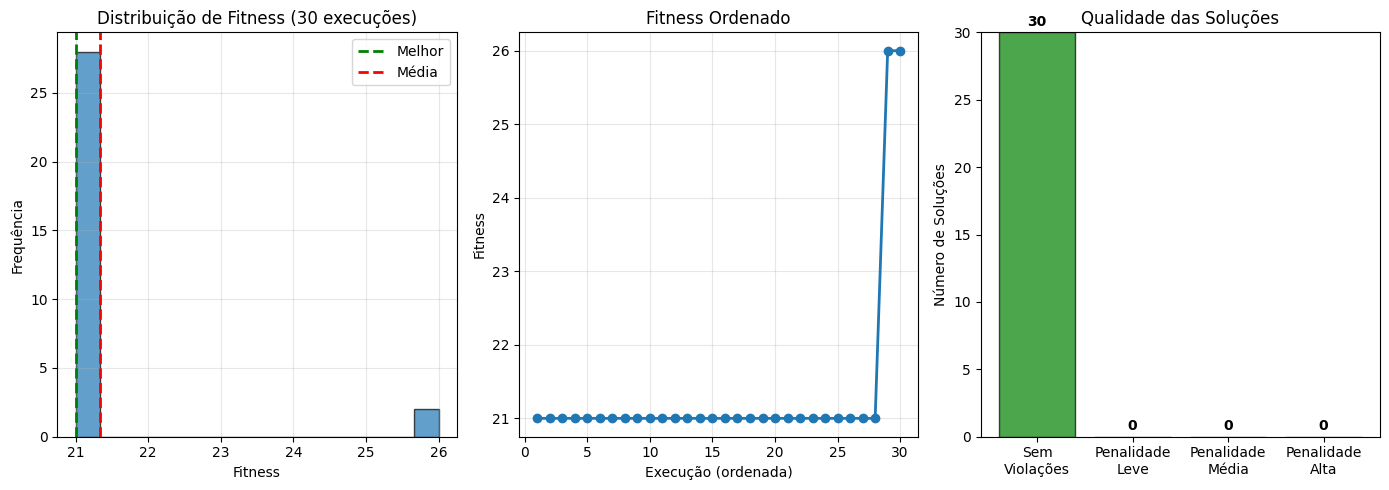


📈 Gráfico salvo em 'fitness_analysis.png'


In [9]:
print("\n=== ANÁLISE DE QUALIDADE DAS SOLUÇÕES ===")

fitness_values = [sol.target.fitness for sol in solutions]
execution_times = [t[0] for t in times]

print(f"\n📊 Estatísticas de Fitness:")
print(f"  Melhor fitness: {min(fitness_values):.2f}")
print(f"  Pior fitness: {max(fitness_values):.2f}")
print(f"  Média: {np.mean(fitness_values):.2f}")
print(f"  Desvio padrão: {np.std(fitness_values):.2f}")

print(f"\n⏱️  Estatísticas de Tempo:")
print(f"  Tempo médio: {np.mean(execution_times):.4f}s")
print(f"  Tempo total: {sum(execution_times):.2f}s")

# Verifica se há penalidades altas (indício de violações)
high_penalty_count = sum(1 for f in fitness_values if f > 10000)
medium_penalty_count = sum(1 for f in fitness_values if 1000 < f <= 10000)
low_penalty_count = sum(1 for f in fitness_values if 100 < f <= 1000)
clean_count = sum(1 for f in fitness_values if f <= 100)

print(f"\n🔍 Distribuição de Penalidades:")
print(f"  Soluções sem violações (fitness ≤ 100): {clean_count}/30")
print(f"  Soluções com penalidades leves (100 < fitness ≤ 1000): {low_penalty_count}/30")
print(f"  Soluções com penalidades médias (1000 < fitness ≤ 10000): {medium_penalty_count}/30")
print(f"  Soluções com penalidades altas (fitness > 10000): {high_penalty_count}/30")

if high_penalty_count == 0 and medium_penalty_count == 0:
    print("\n✅ EXCELENTE! Todas as soluções são viáveis ou têm penalidades mínimas!")
elif high_penalty_count == 0:
    print(f"\n✅ BOM! Nenhuma solução com penalidades altas.")
    print(f"   Mas {medium_penalty_count} soluções têm violações de precedência.")
else:
    print(f"\n❌ ATENÇÃO! {high_penalty_count} soluções têm violações graves de restrições")

# Plota distribuição de fitness
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.hist(fitness_values, bins=15, edgecolor='black', alpha=0.7)
plt.xlabel('Fitness')
plt.ylabel('Frequência')
plt.title('Distribuição de Fitness (30 execuções)')
plt.axvline(min(fitness_values), color='g', linestyle='--', label='Melhor', linewidth=2)
plt.axvline(np.mean(fitness_values), color='r', linestyle='--', label='Média', linewidth=2)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(range(1, 31), sorted(fitness_values), marker='o', linewidth=2)
plt.xlabel('Execução (ordenada)')
plt.ylabel('Fitness')
plt.title('Fitness Ordenado')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
categories = ['Sem\nViolações', 'Penalidade\nLeve', 'Penalidade\nMédia', 'Penalidade\nAlta']
counts = [clean_count, low_penalty_count, medium_penalty_count, high_penalty_count]
colors = ['green', 'yellow', 'orange', 'red']
plt.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Número de Soluções')
plt.title('Qualidade das Soluções')
plt.ylim(0, 30)
for i, v in enumerate(counts):
    plt.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('fitness_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📈 Gráfico salvo em 'fitness_analysis.png'")